# Driven Imposters

In [1]:
from BeyoundEffMass import *
from scipy.interpolate import UnivariateSpline
from tqdm.notebook import tqdm

## Loading data for InSb

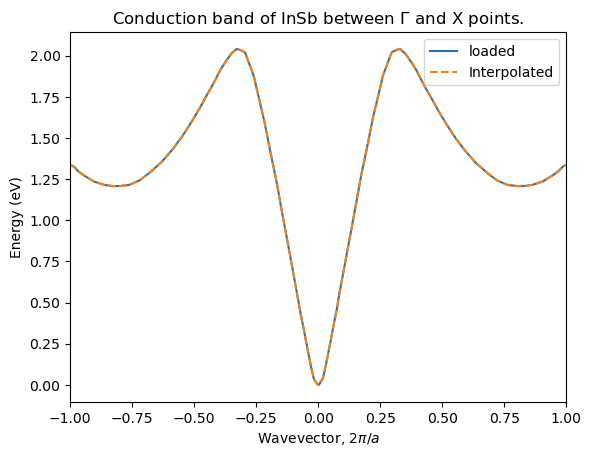

In [2]:
k, E_band = np.loadtxt("energy_xband_InSb.dat").T
# Interpolating

conduction_band = UnivariateSpline(k, E_band, s=0)
a = 0.64794e-9

plt.title(r"Conduction band of InSb between $\Gamma$ and X points.")
plt.plot(k / (2 * np.pi / a), E_band / e, label="loaded")
plt.xlabel(r"Wavevector, $2\pi/a$")
plt.ylabel("Energy (eV)")

plt.plot(k / (2 * np.pi / a), conduction_band(k) / e, "--", label="Interpolated")

plt.xlim(-1, 1)

plt.legend()
plt.show()

Initial pulse

In [3]:
E0 = 20e3 / 1e-2 # ******
f0 = 1e12
τd = 1e-12 #0.5e-12

def Ez_init(x):
    t = x / c
    return E0 * np.exp(-(t / τd) ** 2) * np.sin(2 * np.pi * f0 * t)

In [4]:
x, Δx1 = np.linspace(-25 * c * τd, 3 * c * τd, 2000, retstep=True)

Ez_init = Ez_init(x)

In [5]:
# Note that in the article Δx1 = 5e-6
Δx1

4.199194009004501e-06

In [6]:
# Sample length
d = 0.5e-3

Δx2 = 1.25e-6

Δt = 0.01 * min(Δx1, Δx2) / c

N2 = int(round(d / Δx2))

selecting different electron concentrations

In [7]:
n_target = 6.3e13 / 1e-6
n = 11e13 / 1e-6

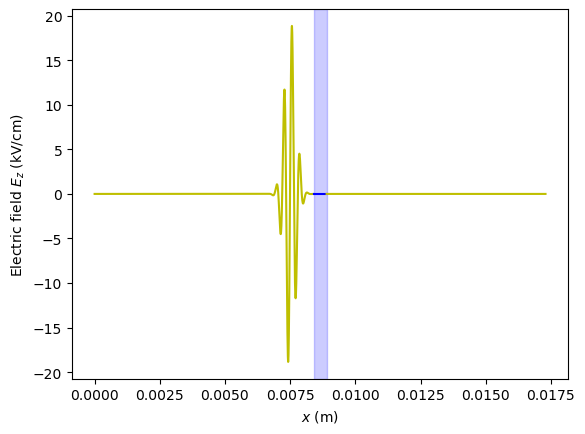

In [8]:
params = dict( 
    Δx1 = Δx1, 
    
    Δx2 = Δx2,
    N2 = N2,
    
    Ez_init = Ez_init, 
    
    diff_E = conduction_band.derivative(), 
    
    epsilon_infty = 15., #15.6,
    γ = 0.5e12,
)

target_sys = CBeyondEffMass(
    Δt = Δt, 
    n = n_target,
    **params
)

target_sys.plot_Ez()

  0%|          | 0/300000 [00:00<?, ?it/s]

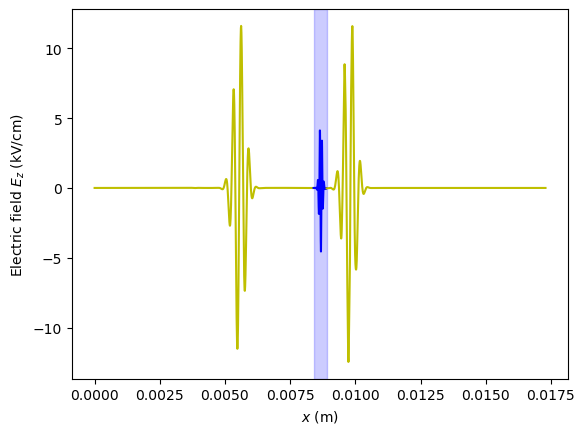

In [9]:
# propagation
n_steps = 300000
t = n_steps * Δt

for _ in tqdm(range(n_steps)):
    target_sys.single_step_propagation()

target_sys.plot_Ez()

## Get the pulse to get the driven imposter by moving backwards in time

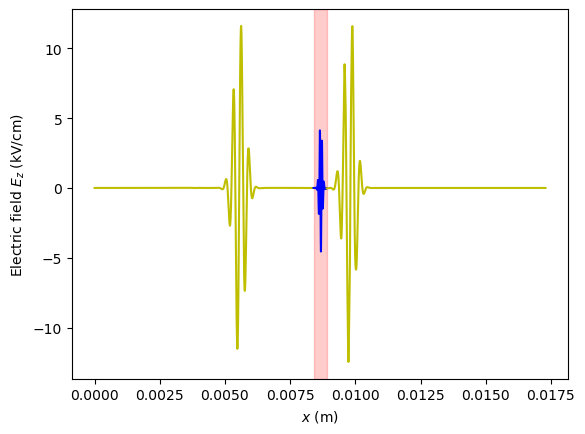

In [10]:
# Copying the propagator

sys_back_in_time = CBeyondEffMass(
    Δt = -Δt, 
    n = n,
    **params
)

sys_back_in_time.Ez1[:] = target_sys.Ez1
sys_back_in_time.Ez2[:] = target_sys.Ez2
sys_back_in_time.Ez3[:] = target_sys.Ez3

sys_back_in_time.Hy1[:] = target_sys.Hy1
sys_back_in_time.Hy2[:] = target_sys.Hy2
sys_back_in_time.Hy3[:] = target_sys.Hy3

sys_back_in_time.Dz2[:] = target_sys.Dz2

sys_back_in_time.PNL[:] = target_sys.PNL
sys_back_in_time.k[:] = target_sys.k

sys_back_in_time.plot_Ez(bulk_color='r')

  0%|          | 0/300000 [00:00<?, ?it/s]

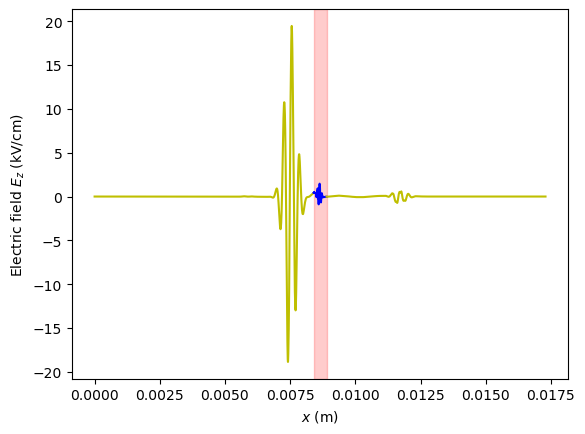

In [11]:
# Propagating backwards in time
for _ in tqdm(range(n_steps)):
    sys_back_in_time.single_step_propagation()

sys_back_in_time.plot_Ez(bulk_color='r')

### Plotting input fields

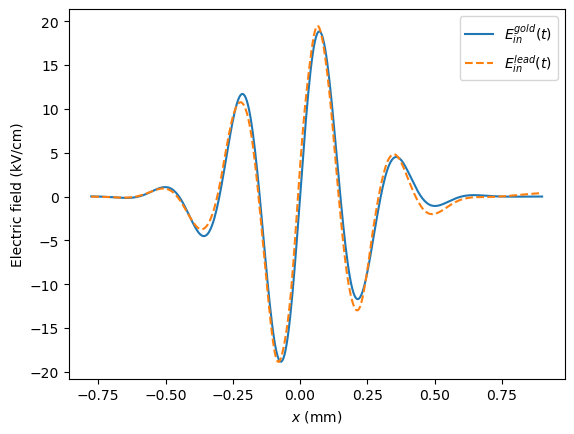

In [27]:
cut_off = -400

# "Initial field"
plt.plot(x[cut_off:] * 1e3, Ez_init[cut_off:] / 1e5, label="$E_{in}^{gold}(t)$") 

# "Back propagated field"
plt.plot(x[cut_off:] * 1e3, sys_back_in_time.Ez1[cut_off:] / 1e5, '--', label = "$E_{in}^{lead}(t)$") 


plt.xlabel("$x$ (mm)")
plt.ylabel("Electric field (kV/cm)")

plt.legend()

plt.savefig("input_fields.pdf")

plt.show()

## Forward propagating to check that the output has been reproduced

(0.005, 0.01)

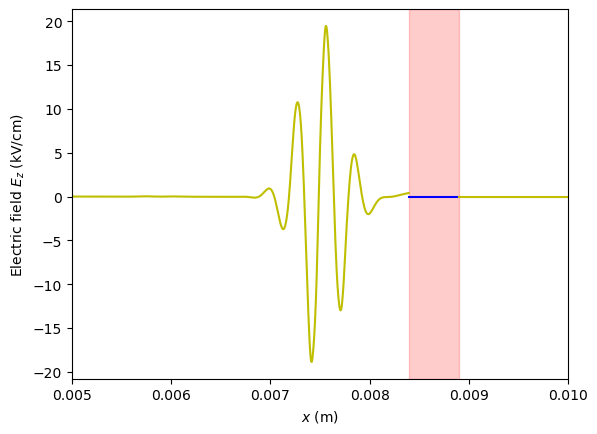

In [13]:
# Copying the propagator

sys_forwad_in_time = CBeyondEffMass(
    Δt = Δt, 
    n = n,
    **params
)

sys_forwad_in_time.Ez1[:] = sys_back_in_time.Ez1
sys_forwad_in_time.Hy1[:] = sys_back_in_time.Hy1

sys_forwad_in_time.plot_Ez(bulk_color='r')
plt.xlim([0.005, 0.01])

  0%|          | 0/300000 [00:00<?, ?it/s]

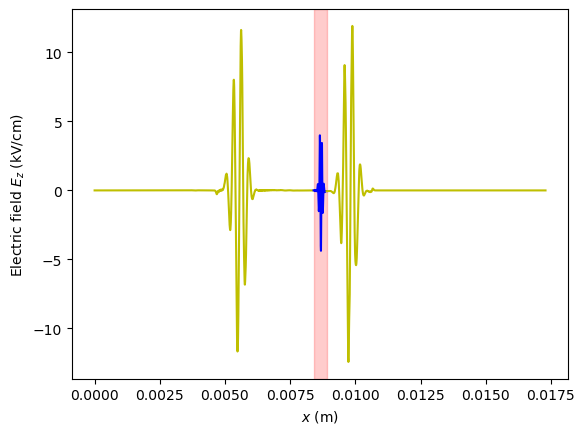

In [14]:
# Propagating backwards in time
for _ in tqdm(range(n_steps)):
    sys_forwad_in_time.single_step_propagation()

sys_forwad_in_time.plot_Ez(bulk_color='r')

### Plotting output fields

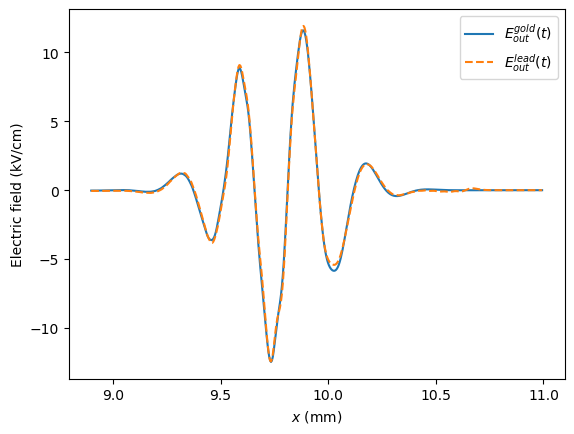

In [28]:
cut_off = 500

# "Target transmitted field"
plt.plot(target_sys.x3[:cut_off] * 1e3, target_sys.Ez3[:cut_off] / 1e5, label="$E_{out}^{gold}(t)$")

# "System transmitted field"
plt.plot(sys_forwad_in_time.x3[:cut_off] * 1e3, sys_forwad_in_time.Ez3[:cut_off] / 1e5, '--', label="$E_{out}^{lead}(t)$")

#
plt.xlabel("$x$ (mm)")
plt.ylabel("Electric field (kV/cm)")

plt.legend()

plt.savefig("output_fields.pdf")

plt.show()

## Check

  0%|          | 0/300000 [00:00<?, ?it/s]

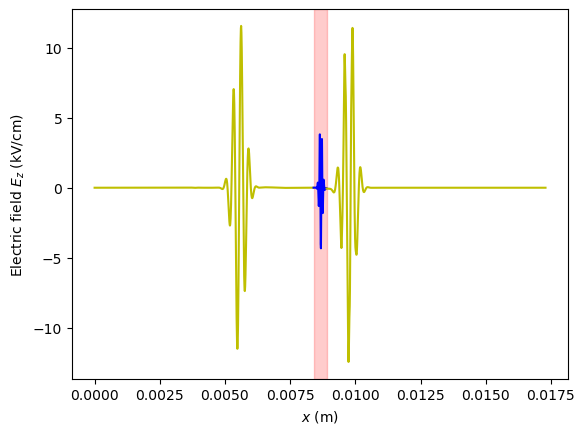

In [16]:
sys_check_org_pulse = CBeyondEffMass(
    Δt = Δt, 
    n = n,
    **params
)

for _ in tqdm(range(n_steps)):
    sys_check_org_pulse.single_step_propagation()
    
sys_check_org_pulse.plot_Ez(bulk_color='r')

In [17]:
### Checking that the right field is important the difference

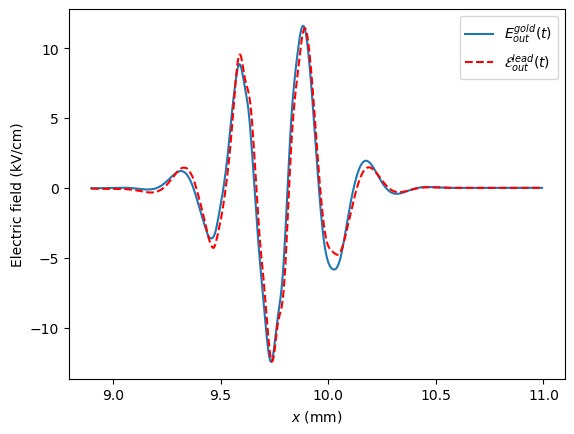

In [29]:


cut_off = 500

# "Target transmitted field"
plt.plot(target_sys.x3[:cut_off] * 1e3, target_sys.Ez3[:cut_off] / 1e5, label="$E_{out}^{gold}(t)$")

# "System transmitted field"
plt.plot(
    sys_check_org_pulse.x3[:cut_off] * 1e3, sys_check_org_pulse.Ez3[:cut_off] / 1e5, 
    'r--', label=r"$\mathcal{E}_{out}^{lead}(t)$"
)

#
plt.xlabel("$x$ (mm)")
plt.ylabel("Electric field (kV/cm)")

plt.legend()

plt.savefig("check_fields.pdf")
plt.show()